<a href="https://colab.research.google.com/github/SJinLee/Diffusion/blob/main/02.denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np


In [2]:
def build(width, height, depth, filters=(32, 64), latentDim=16):
    # initialize the input shape to be "channels last" along with
    # the channels dimension itself
    # channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1
    # define the input to the encoder
    inputs = Input(shape=inputShape)
    x = inputs
    # loop over the number of filters
    for f in filters:
        # apply a CONV => RELU => BN operation
        x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chanDim)(x)
    # flatten the network and then construct our latent vector
    volumeSize = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latentDim)(x)
    # build the encoder model
    encoder = Model(inputs, latent, name="encoder")
    # start building the decoder model which will accept the
    # output of the encoder as its inputs
    latentInputs = Input(shape=(latentDim,))
    x = Dense(np.prod(volumeSize[1:]))(latentInputs)
    x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
    # loop over our number of filters again, but this time in
    # reverse order
    for f in filters[::-1]:
        # apply a CONV_TRANSPOSE => RELU => BN operation
        x = Conv2DTranspose(f, (3, 3), strides=2,
            padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chanDim)(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)
    # build the decoder model
    decoder = Model(latentInputs, outputs, name="decoder")
    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)),
        name="autoencoder")
    # return a 3-tuple of the encoder, decoder, and autoencoder
    return (encoder, decoder, autoencoder)

In [4]:
import matplotlib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [5]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...
11490434/11490434 [==============================] - 0s 0us/step


In [7]:
trainX[0].shape

(28, 28, 1)

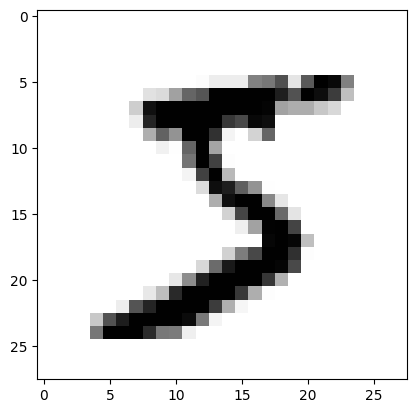

In [8]:
plt.imshow(trainX[0],cmap='binary')

In [9]:
# sample noise from a random normal distribution centered at 0.5 (since
# our images lie in the range [0, 1]) and a standard deviation of 0.5
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

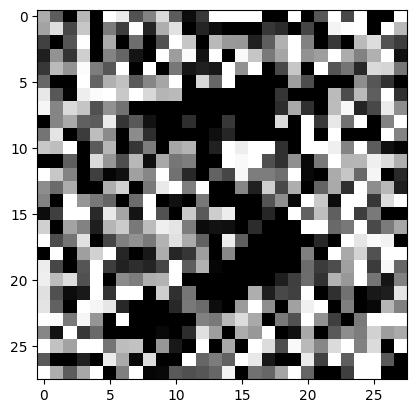

In [10]:
plt.imshow(trainXNoisy[0],cmap='binary')

In [11]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] building autoencoder...


In [12]:
# train the convolutional autoencoder
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=EPOCHS,
	batch_size=BS)

Epoch 1/25
1875/1875 [==============================] - 19s 6ms/step - loss: 0.0284 - val_loss: 0.0194
Epoch 2/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0189 - val_loss: 0.0178
Epoch 3/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0178 - val_loss: 0.0178
Epoch 4/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0172 - val_loss: 0.0169
Epoch 5/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0168 - val_loss: 0.0175
Epoch 6/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0165 - val_loss: 0.0166
Epoch 7/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0162 - val_loss: 0.0164
Epoch 8/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0160 - val_loss: 0.0164
Epoch 9/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 10/25
1875/1875 [==============================] - 11s 6ms/step - l

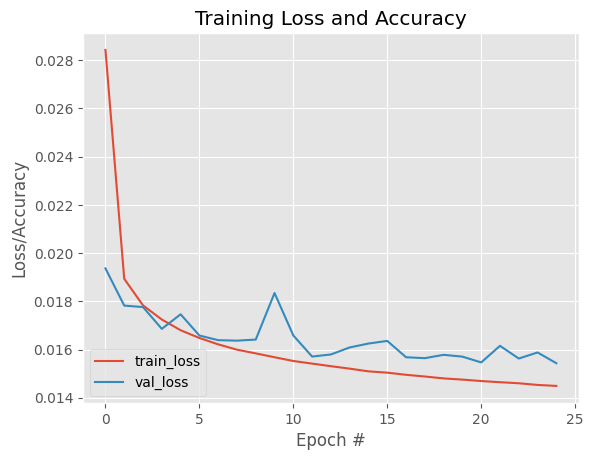

In [13]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [14]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testXNoisy)

[INFO] making predictions...
313/313 [==============================] - 2s 6ms/step


In [15]:
decoded.shape

(10000, 28, 28, 1)

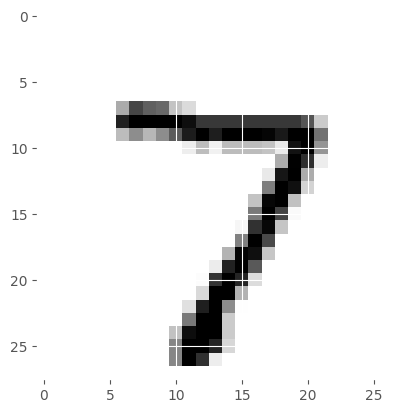

In [16]:
plt.imshow(testX[0],cmap='binary')

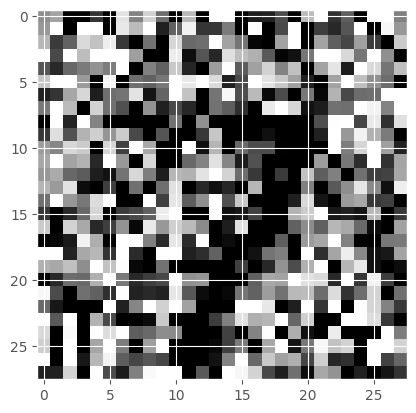

In [18]:
plt.imshow(testXNoisy[0],cmap='binary')

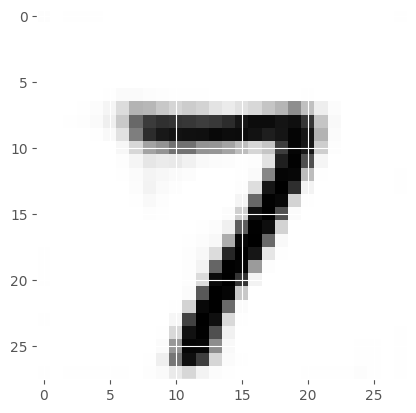

In [19]:
plt.imshow(decoded[0],cmap='binary')

In [20]:
testAll0 = np.concatenate([testX[0],testXNoisy[0],decoded[0]],axis=1)

In [21]:
testAll0.shape

(28, 84, 1)

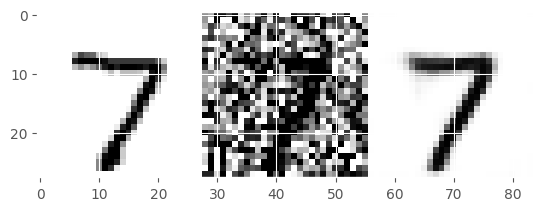

In [22]:
plt.imshow(testAll0,cmap='binary')

In [23]:
decoded_org = autoencoder.predict(testX)

313/313 [==============================] - 1s 3ms/step


In [24]:
testAll0 = np.concatenate([testX[0],testXNoisy[0],decoded[0],decoded_org[0]],axis=1)

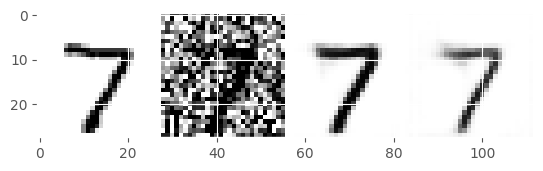

In [25]:
plt.imshow(testAll0,cmap='binary')